In [3]:
%pip install python-dotenv


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Free-form Text to Route Generation
# Using Ollama Mistral + Google Maps API

import json
import requests
import os
from typing import Dict, Any, Optional
import re

# For Ollama integration
import httpx

print("Setting up dependencies for route generation system...")
print("Required: Ollama with Mistral model, Google Maps API key")

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

# Verify the API key is loaded
api_key = os.getenv('GOOGLE_MAPS_API_KEY')
if api_key:
    print(f"✅ Google Maps API key loaded: {api_key[:10]}...{api_key[-4:]}")
else:
    print("❌ Google Maps API key not found")

Setting up dependencies for route generation system...
Required: Ollama with Mistral model, Google Maps API key
✅ Google Maps API key loaded: AIzaSyDfb-...QAvQ


In [6]:
class OllamaMistralParser:
    """
    Class to handle interaction with Ollama Mistral model for parsing route requests
    """
    
    def __init__(self, base_url: str = "http://localhost:11434"):
        self.base_url = base_url
        self.model = "mistral"
    
    def parse_route_request(self, text: str, user_preferences: Dict[str, Any] = None) -> Dict[str, Any]:
        """
        Parse natural language route request using Mistral
        
        Args:
            text: Natural language route request
            user_preferences: User preferences for routing
            
        Returns:
            Structured output with origin, destination, and preferences
        """
        
        # Default preferences if none provided
        if user_preferences is None:
            user_preferences = {
                "mode": "driving",
                "avoid": [],
                "optimize": "time"  # or "distance"
            }
        
        # Create a structured prompt for Mistral
        prompt = f"""
        Parse the following route request and extract the key information in JSON format.
        
        Route request: "{text}"
        User preferences: {json.dumps(user_preferences)}
        
        Extract and return a JSON object with the following structure:
        {{
            "origin": "specific location or address",
            "destination": "specific location or address", 
            "preferences": {{
                "mode": "driving/walking/transit",
                "avoid": ["tolls", "highways", "ferries"],
                "optimize": "time/distance"
            }},
            "confidence": 0.0-1.0
        }}
        
        Only return valid JSON, no other text.
        """
        
        try:
            response = requests.post(
                f"{self.base_url}/api/generate",
                json={
                    "model": self.model,
                    "prompt": prompt,
                    "stream": False,
                    "format": "json"
                }
            )
            
            if response.status_code == 200:
                result = response.json()
                # Parse the response to extract JSON
                response_text = result.get("response", "")
                
                # Try to extract JSON from the response
                try:
                    parsed_result = json.loads(response_text)
                    return parsed_result
                except json.JSONDecodeError:
                    # Fallback parsing if JSON is malformed
                    return self._fallback_parse(text, user_preferences)
            else:
                print(f"Ollama request failed: {response.status_code}")
                return self._fallback_parse(text, user_preferences)
                
        except Exception as e:
            print(f"Error connecting to Ollama: {e}")
            return self._fallback_parse(text, user_preferences)
    
    def _fallback_parse(self, text: str, user_preferences: Dict[str, Any]) -> Dict[str, Any]:
        """
        Fallback parsing using regex if Ollama is not available
        """
        # Simple regex-based parsing as fallback
        from_match = re.search(r'from\s+(.+?)\s+to', text, re.IGNORECASE)
        to_match = re.search(r'to\s+(.+?)(?:\s|$)', text, re.IGNORECASE)
        
        origin = from_match.group(1).strip() if from_match else ""
        destination = to_match.group(1).strip() if to_match else ""
        
        return {
            "origin": origin,
            "destination": destination,
            "preferences": user_preferences,
            "confidence": 0.6  # Lower confidence for fallback
        }

# Initialize the parser
parser = OllamaMistralParser()
print("Ollama Mistral parser initialized")


Ollama Mistral parser initialized




### 1. Ollama with Mistral Model
```bash
# Install Ollama (if not already installed)
curl -fsSL https://ollama.ai/install.sh | sh

# Pull the Mistral model
ollama pull mistral

# Start Ollama service (runs on localhost:11434 by default)
ollama serve
```

### 2. Google Maps API Key
1. Go to [Google Cloud Console](https://console.cloud.google.com/)
2. Create a new project or select an existing one
3. Enable the following APIs:
   - Geocoding API
   - Directions API
4. Create credentials (API Key)
5. Set the environment variable:
```bash
export GOOGLE_MAPS_API_KEY="your_api_key_here"
```

### 3. Python Dependencies
```bash
pip install requests httpx python-dotenv
```


In [78]:
# 🎯 SMART WAYPOINT FILTERING SYSTEM
# Prevents travel time explosion by intelligently filtering waypoints

import math
from typing import List, Tuple

class SmartWaypointFilter:
    """
    Intelligent waypoint filtering to prevent travel time explosion
    """
    
    def __init__(self, api_key: str = None):
        self.api_key = api_key or os.getenv('GOOGLE_MAPS_API_KEY')
        self.base_url = "https://maps.googleapis.com/maps/api"
        
        # Configuration for reasonable routing
        self.MAX_WAYPOINTS = 3  # Google Maps allows up to 25, but 3-4 is reasonable
        self.MAX_DETOUR_RATIO = 4  # Allow max 50% increase in travel time
        self.MIN_WAYPOINT_DISTANCE = 100  # Minimum 2km between waypoints (meters)
        self.MAX_WAYPOINT_DETOUR = 10000  # Max 10km detour for any single waypoint
        
    def calculate_distance(self, lat1: float, lng1: float, lat2: float, lng2: float) -> float:
        """
        Calculate haversine distance between two points in meters
        """
        R = 6371000  # Earth's radius in meters
        
        lat1_rad = math.radians(lat1)
        lat2_rad = math.radians(lat2)
        delta_lat = math.radians(lat2 - lat1)
        delta_lng = math.radians(lng2 - lng1)
        
        a = (math.sin(delta_lat/2) * math.sin(delta_lat/2) + 
             math.cos(lat1_rad) * math.cos(lat2_rad) * 
             math.sin(delta_lng/2) * math.sin(delta_lng/2))
        
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return R * c
    
    def get_direct_route_info(self, origin: str, destination: str) -> Dict[str, Any]:
        """
        Get baseline direct route for comparison
        """
        url = f"{self.base_url}/directions/json"
        params = {
            'origin': origin,
            'destination': destination,
            'key': self.api_key,
            'mode': 'driving'
        }
        
        try:
            response = requests.get(url, params=params)
            data = response.json()
            
            if data['status'] == 'OK' and data['routes']:
                route = data['routes'][0]
                leg = route['legs'][0]
                
                return {
                    'success': True,
                    'distance_meters': leg['distance']['value'],
                    'duration_seconds': leg['duration']['value'],
                    'distance_text': leg['distance']['text'],
                    'duration_text': leg['duration']['text']
                }
            else:
                return {'success': False, 'error': data.get('status', 'Unknown error')}
                
        except Exception as e:
            return {'success': False, 'error': str(e)}
    
    def filter_waypoints_intelligently(self, origin: str, destination: str, 
                                     waypoints: List[Dict[str, Any]], 
                                     user_intent: str = "") -> Dict[str, Any]:
        """
        Intelligently filter waypoints to prevent travel time explosion
        """
        print(f"🎯 SMART WAYPOINT FILTERING")
        print("=" * 50)
        print(f"📍 Origin: {origin}")
        print(f"📍 Destination: {destination}")
        print(f"🎯 User Intent: {user_intent}")
        print(f"📊 Initial Waypoints: {len(waypoints)}")
        
        # Step 1: Get baseline direct route
        print(f"\n1️⃣ Getting baseline direct route...")
        direct_route = self.get_direct_route_info(origin, destination)
        
        if not direct_route['success']:
            print(f"❌ Failed to get direct route: {direct_route['error']}")
            return {'success': False, 'error': direct_route['error']}
        
        baseline_duration = direct_route['duration_seconds']
        baseline_distance = direct_route['distance_meters']
        
        print(f"   📏 Direct distance: {direct_route['distance_text']}")
        print(f"   ⏱️ Direct duration: {direct_route['duration_text']}")
        print(f"   🎯 Max allowed duration: {int(baseline_duration * self.MAX_DETOUR_RATIO / 60)} mins")
        
        # Step 2: Filter by quantity (max waypoints)
        if len(waypoints) > self.MAX_WAYPOINTS:
            print(f"\n2️⃣ Limiting to {self.MAX_WAYPOINTS} waypoints (from {len(waypoints)})")
            waypoints = self._prioritize_waypoints(waypoints, user_intent)[:self.MAX_WAYPOINTS]
        else:
            print(f"\n2️⃣ Waypoint count OK: {len(waypoints)} ≤ {self.MAX_WAYPOINTS}")
        
        # Step 3: Filter by geographical reasonableness
        print(f"\n3️⃣ Filtering by geographical reasonableness...")
        filtered_waypoints = self._filter_by_geography(origin, destination, waypoints)
        
        print(f"   📊 After geography filter: {len(filtered_waypoints)} waypoints")
        
        # Step 4: Test actual route with filtered waypoints
        print(f"\n4️⃣ Testing route with filtered waypoints...")
        final_waypoints = self._test_route_performance(
            origin, destination, filtered_waypoints, baseline_duration
        )
        
        print(f"   ✅ Final optimized waypoints: {len(final_waypoints)}")
        
        # Step 5: Calculate improvement metrics
        if final_waypoints:
            route_test = self._get_route_with_waypoints(origin, destination, final_waypoints)
            if route_test['success']:
                actual_duration = route_test['duration_seconds']
                time_increase = ((actual_duration - baseline_duration) / baseline_duration) * 100
                
                print(f"\n📊 FILTERING RESULTS:")
                print(f"   📍 Original waypoints: {len(waypoints)}")
                print(f"   ✅ Final waypoints: {len(final_waypoints)}")
                print(f"   ⏱️ Direct time: {direct_route['duration_text']}")
                print(f"   ⏱️ With waypoints: {int(actual_duration/60)} mins")
                print(f"   📈 Time increase: +{time_increase:.1f}%")
                print(f"   🎯 Within limits: {'✅' if time_increase <= 50 else '❌'}")
        
        return {
            'success': True,
            'filtered_waypoints': final_waypoints,
            'baseline_route': direct_route,
            'original_count': len(waypoints),
            'final_count': len(final_waypoints),
            'filtering_applied': len(waypoints) != len(final_waypoints)
        }
    
    def _prioritize_waypoints(self, waypoints: List[Dict[str, Any]], user_intent: str) -> List[Dict[str, Any]]:
        """
        Prioritize waypoints based on user intent and reasoning quality
        """
        # Score waypoints based on reasoning quality and intent match
        for wp in waypoints:
            score = 0
            reasoning = wp.get('reasoning', '').lower()
            intent_lower = user_intent.lower()
            
            # Higher score for reasoning that matches user intent
            intent_keywords = ['romantic', 'scenic', 'instagram', 'photo', 'view', 'sunset', 'beautiful']
            for keyword in intent_keywords:
                if keyword in intent_lower and keyword in reasoning:
                    score += 2
            
            # Higher score for detailed reasoning
            score += len(reasoning.split()) * 0.1
            
            # Higher score for famous landmarks
            famous_keywords = ['golden gate', 'twin peaks', 'lombard', 'coit tower', 'palace', 'pier']
            for keyword in famous_keywords:
                if keyword in reasoning:
                    score += 1
            
            wp['priority_score'] = score
        
        # Sort by priority score (highest first)
        return sorted(waypoints, key=lambda x: x.get('priority_score', 0), reverse=True)
    
    def _filter_by_geography(self, origin: str, destination: str, waypoints: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Filter waypoints based on geographical reasonableness
        """
        # Get coordinates for origin and destination
        origin_coords = self._geocode_location(origin)
        dest_coords = self._geocode_location(destination)
        
        if not (origin_coords and dest_coords):
            print("   ⚠️ Could not geocode origin/destination, keeping all waypoints")
            return waypoints
        
        filtered = []
        for wp in waypoints:
            if not ('lat' in wp and 'lng' in wp):
                continue
                
            wp_lat, wp_lng = wp['lat'], wp['lng']
            
            # Calculate distances
            dist_from_origin = self.calculate_distance(
                origin_coords['lat'], origin_coords['lng'], wp_lat, wp_lng
            )
            dist_to_dest = self.calculate_distance(
                wp_lat, wp_lng, dest_coords['lat'], dest_coords['lng']
            )
            direct_distance = self.calculate_distance(
                origin_coords['lat'], origin_coords['lng'], dest_coords['lat'], dest_coords['lng']
            )
            
            # Calculate detour distance
            detour_distance = (dist_from_origin + dist_to_dest) - direct_distance
            
            # Filter criteria
            reasonable = True
            reasons = []
            
            if detour_distance > self.MAX_WAYPOINT_DETOUR:
                reasonable = False
                reasons.append(f"detour too large ({detour_distance/1000:.1f}km)")
            
            # Check if waypoints are too close to each other
            for other_wp in filtered:
                if self.calculate_distance(wp_lat, wp_lng, other_wp['lat'], other_wp['lng']) < self.MIN_WAYPOINT_DISTANCE:
                    reasonable = False
                    reasons.append("too close to another waypoint")
                    break
            
            if reasonable:
                filtered.append(wp)
                print(f"   ✅ Kept: {wp.get('location', 'Unknown')} (detour: {detour_distance/1000:.1f}km)")
            else:
                print(f"   ❌ Filtered: {wp.get('location', 'Unknown')} - {', '.join(reasons)}")
        
        return filtered
    
    def _test_route_performance(self, origin: str, destination: str, 
                              waypoints: List[Dict[str, Any]], baseline_duration: int) -> List[Dict[str, Any]]:
        """
        Test route performance and remove waypoints that cause excessive delays
        """
        if not waypoints:
            return waypoints
            
        # Test full route
        route_result = self._get_route_with_waypoints(origin, destination, waypoints)
        
        if not route_result['success']:
            print(f"   ❌ Route test failed: {route_result['error']}")
            return []
        
        actual_duration = route_result['duration_seconds']
        time_ratio = actual_duration / baseline_duration
        
        if time_ratio <= self.MAX_DETOUR_RATIO:
            print(f"   ✅ Route performance OK: {time_ratio:.1f}x baseline")
            return waypoints
        
        print(f"   ⚠️ Route too slow: {time_ratio:.1f}x baseline, optimizing...")
        
        # If too slow, try removing lowest priority waypoints one by one
        sorted_waypoints = sorted(waypoints, key=lambda x: x.get('priority_score', 0), reverse=True)
        
        for i in range(len(sorted_waypoints) - 1, 0, -1):
            test_waypoints = sorted_waypoints[:i]
            test_result = self._get_route_with_waypoints(origin, destination, test_waypoints)
            
            if test_result['success']:
                test_ratio = test_result['duration_seconds'] / baseline_duration
                if test_ratio <= self.MAX_DETOUR_RATIO:
                    print(f"   ✅ Optimized to {len(test_waypoints)} waypoints: {test_ratio:.1f}x baseline")
                    return test_waypoints
        
        print(f"   ⚠️ No waypoint combination meets performance criteria")
        return []
    
    def _get_route_with_waypoints(self, origin: str, destination: str, 
                                waypoints: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        Test route with specific waypoints
        """
        url = f"{self.base_url}/directions/json"
        params = {
            'origin': origin,
            'destination': destination,
            'key': self.api_key,
            'mode': 'driving'
        }
        
        if waypoints:
            waypoint_coords = [f"{wp['lat']},{wp['lng']}" for wp in waypoints if 'lat' in wp and 'lng' in wp]
            if waypoint_coords:
                params['waypoints'] = '|'.join(waypoint_coords)
        
        try:
            response = requests.get(url, params=params)
            data = response.json()
            
            if data['status'] == 'OK' and data['routes']:
                route = data['routes'][0]
                total_duration = sum(leg['duration']['value'] for leg in route['legs'])
                total_distance = sum(leg['distance']['value'] for leg in route['legs'])
                
                return {
                    'success': True,
                    'duration_seconds': total_duration,
                    'distance_meters': total_distance
                }
            else:
                return {'success': False, 'error': data.get('status', 'Unknown')}
                
        except Exception as e:
            return {'success': False, 'error': str(e)}
    
    def _geocode_location(self, location: str) -> Optional[Dict[str, float]]:
        """
        Geocode a location string to coordinates
        """
        url = f"{self.base_url}/geocode/json"
        params = {'address': location, 'key': self.api_key}
        
        try:
            response = requests.get(url, params=params)
            data = response.json()
            
            if data['status'] == 'OK' and data['results']:
                coords = data['results'][0]['geometry']['location']
                return {'lat': coords['lat'], 'lng': coords['lng']}
        except:
            pass
        
        return None

# Initialize smart waypoint filter
smart_filter = SmartWaypointFilter()
print("🎯 Smart waypoint filtering system initialized")
print(f"   📊 Max waypoints: {smart_filter.MAX_WAYPOINTS}")
print(f"   ⏱️ Max detour ratio: {smart_filter.MAX_DETOUR_RATIO}x")
print(f"   📏 Min waypoint spacing: {smart_filter.MIN_WAYPOINT_DISTANCE/1000}km")


🎯 Smart waypoint filtering system initialized
   📊 Max waypoints: 3
   ⏱️ Max detour ratio: 4x
   📏 Min waypoint spacing: 0.1km


In [82]:
# 🏢 GOOGLE PLACES WAYPOINT DISCOVERY SYSTEM
# Use Google Places API to find relevant waypoints along the route

import polyline
import math
from typing import List, Dict, Any, Tuple

class GooglePlacesWaypointFinder:
    """
    Uses Google Places API to find relevant waypoints along a route path
    """
    
    def __init__(self, api_key: str = None):
        self.api_key = api_key or os.getenv('GOOGLE_MAPS_API_KEY')
        self.base_url = "https://maps.googleapis.com/maps/api"
        
        # Intent-based place type mappings
        self.intent_place_types = {
            'scenic': ['tourist_attraction', 'park', 'natural_feature'],
            'romantic': ['restaurant', 'park', 'tourist_attraction'],
            'instagram': ['tourist_attraction', 'art_gallery', 'museum'],
            'photo': ['tourist_attraction', 'landmark', 'point_of_interest'],
            'food': ['restaurant', 'cafe', 'bakery'],
            'shopping': ['shopping_mall', 'store', 'department_store'],
            'cultural': ['museum', 'art_gallery', 'church', 'synagogue'],
            'nature': ['park', 'natural_feature', 'zoo'],
            'viewpoint': ['tourist_attraction', 'park'],
            'sunset': ['tourist_attraction', 'park'],
            'beautiful': ['tourist_attraction', 'park', 'natural_feature']
        }
        
        # Default place types for general exploration
        self.default_place_types = ['tourist_attraction', 'point_of_interest', 'park']
        
    def find_waypoints_along_route(self, origin: str, destination: str, 
                                 user_intent: str = "", max_waypoints: int = 5) -> Dict[str, Any]:
        """
        Find relevant waypoints along a route using Google Places API
        """
        print(f"🏢 GOOGLE PLACES WAYPOINT DISCOVERY")
        print("=" * 50)
        print(f"📍 Origin: {origin}")
        print(f"📍 Destination: {destination}")
        print(f"🎯 User Intent: {user_intent}")
        
        # Step 1: Get the direct route to establish the path
        print(f"\n1️⃣ Getting direct route path...")
        direct_route = self._get_route_polyline(origin, destination)
        
        if not direct_route['success']:
            return {'success': False, 'error': direct_route['error']}
        
        route_polyline = direct_route['polyline']
        route_bounds = direct_route['bounds']
        
        print(f"   ✅ Route polyline obtained")
        
        # Step 2: Decode polyline to get path coordinates
        print(f"\n2️⃣ Decoding route path...")
        path_points = self._decode_polyline(route_polyline)
        print(f"   📊 Route has {len(path_points)} path points")
        
        # Step 3: Sample points along the route for place searches
        print(f"\n3️⃣ Sampling search points along route...")
        search_points = self._sample_route_points(path_points, num_samples=8)
        print(f"   🎯 Using {len(search_points)} search points")
        
        # Step 4: Determine place types based on user intent
        print(f"\n4️⃣ Determining place types from intent...")
        place_types = self._get_place_types_for_intent(user_intent)
        print(f"   🏷️ Search types: {place_types}")
        
        # Step 5: Search for places near each point
        print(f"\n5️⃣ Searching for places along route...")
        all_places = []
        
        for i, point in enumerate(search_points, 1):
            print(f"   🔍 Searching near point {i}: ({point[0]:.4f}, {point[1]:.4f})")
            places = self._search_places_nearby(point, place_types, radius=2000)
            
            if places['success']:
                found_count = len(places['places'])
                print(f"      ✅ Found {found_count} places")
                all_places.extend(places['places'])
            else:
                print(f"      ❌ Search failed: {places['error']}")
        
        # Step 6: Filter and rank places
        print(f"\n6️⃣ Filtering and ranking places...")
        print(f"   📊 Total places found: {len(all_places)}")
        
        # Remove duplicates and filter by relevance
        unique_places = self._deduplicate_places(all_places)
        print(f"   🔄 After deduplication: {len(unique_places)}")
        
        # Rank by relevance to intent and route
        ranked_places = self._rank_places_by_relevance(unique_places, user_intent, path_points)
        
        # Select top waypoints
        selected_waypoints = ranked_places[:max_waypoints]
        print(f"   🎯 Selected top {len(selected_waypoints)} waypoints")
        
        # Step 7: Format as waypoints
        formatted_waypoints = []
        for i, place in enumerate(selected_waypoints, 1):
            waypoint = {
                'location': place['name'],
                'address': place.get('vicinity', place.get('formatted_address', '')),
                'lat': place['geometry']['location']['lat'],
                'lng': place['geometry']['location']['lng'],
                'place_id': place['place_id'],
                'types': place.get('types', []),
                'rating': place.get('rating', 0),
                'reasoning': f"Google Places found: {place['name']} - {place.get('types', ['attraction'])[0].replace('_', ' ').title()}",
                'source': 'google_places',
                'relevance_score': place.get('relevance_score', 0)
            }
            formatted_waypoints.append(waypoint)
            print(f"   {i}. {waypoint['location']} (Rating: {waypoint['rating']}, Score: {waypoint['relevance_score']:.2f})")
        
        return {
            'success': True,
            'waypoints': formatted_waypoints,
            'total_places_found': len(all_places),
            'unique_places': len(unique_places),
            'search_points_used': len(search_points),
            'place_types_searched': place_types,
            'route_info': direct_route
        }
    
    def _get_route_polyline(self, origin: str, destination: str) -> Dict[str, Any]:
        """Get route polyline from Google Directions API"""
        url = f"{self.base_url}/directions/json"
        params = {
            'origin': origin,
            'destination': destination,
            'key': self.api_key,
            'mode': 'driving'
        }
        
        try:
            response = requests.get(url, params=params)
            data = response.json()
            
            if data['status'] == 'OK' and data['routes']:
                route = data['routes'][0]
                return {
                    'success': True,
                    'polyline': route['overview_polyline']['points'],
                    'bounds': route['bounds'],
                    'distance': route['legs'][0]['distance'],
                    'duration': route['legs'][0]['duration']
                }
            else:
                return {'success': False, 'error': f"Directions API error: {data.get('status')}"}
                
        except Exception as e:
            return {'success': False, 'error': f"Request failed: {str(e)}"}
    
    def _decode_polyline(self, encoded_polyline: str) -> List[Tuple[float, float]]:
        """Decode Google polyline to list of lat/lng coordinates"""
        try:
            return polyline.decode(encoded_polyline)
        except Exception as e:
            print(f"   ⚠️ Polyline decode failed: {e}")
            return []
    
    def _sample_route_points(self, path_points: List[Tuple[float, float]], num_samples: int = 8) -> List[Tuple[float, float]]:
        """Sample evenly spaced points along the route for place searches"""
        if len(path_points) <= num_samples:
            return path_points
        
        # Sample evenly along the route
        step = len(path_points) // num_samples
        sampled = []
        
        for i in range(0, len(path_points), step):
            if len(sampled) < num_samples:
                sampled.append(path_points[i])
        
        return sampled
    
    def _get_place_types_for_intent(self, user_intent: str) -> List[str]:
        """Determine Google Places types based on user intent"""
        intent_lower = user_intent.lower()
        place_types = set()
        
        # Check for intent keywords
        for intent_key, types in self.intent_place_types.items():
            if intent_key in intent_lower:
                place_types.update(types)
        
        # If no specific intent found, use defaults
        if not place_types:
            place_types = set(self.default_place_types)
        
        return list(place_types)
    
    def _search_places_nearby(self, location: Tuple[float, float], place_types: List[str], radius: int = 2000) -> Dict[str, Any]:
        """Search for places near a specific location"""
        url = f"{self.base_url}/place/nearbysearch/json"
        
        all_places = []
        
        # Search for each place type
        for place_type in place_types:
            params = {
                'location': f"{location[0]},{location[1]}",
                'radius': radius,
                'type': place_type,
                'key': self.api_key
            }
            
            try:
                response = requests.get(url, params=params)
                data = response.json()
                
                if data['status'] == 'OK':
                    all_places.extend(data.get('results', []))
                elif data['status'] != 'ZERO_RESULTS':
                    print(f"      ⚠️ Places API warning for {place_type}: {data['status']}")
                    
            except Exception as e:
                print(f"      ❌ Places search failed for {place_type}: {e}")
        
        return {
            'success': True,
            'places': all_places
        }
    
    def _deduplicate_places(self, places: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Remove duplicate places based on place_id"""
        seen_place_ids = set()
        unique_places = []
        
        for place in places:
            place_id = place.get('place_id')
            if place_id and place_id not in seen_place_ids:
                seen_place_ids.add(place_id)
                unique_places.append(place)
        
        return unique_places
    
    def _rank_places_by_relevance(self, places: List[Dict[str, Any]], user_intent: str, route_points: List[Tuple[float, float]]) -> List[Dict[str, Any]]:
        """Rank places by relevance to user intent and proximity to route"""
        intent_lower = user_intent.lower()
        
        for place in places:
            score = 0
            
            # Base score from rating
            rating = place.get('rating', 0)
            score += rating * 2  # Rating contributes 0-10 points
            
            # Bonus for high-rated places
            if rating >= 4.0:
                score += 5
            
            # Intent matching bonus
            place_types = place.get('types', [])
            place_name = place.get('name', '').lower()
            
            for intent_key in self.intent_place_types.keys():
                if intent_key in intent_lower:
                    # Check if place types match intent
                    intent_types = self.intent_place_types[intent_key]
                    if any(ptype in place_types for ptype in intent_types):
                        score += 10
                    
                    # Check if name matches intent
                    if intent_key in place_name:
                        score += 5
            
            # Popular place types get bonus
            popular_types = ['tourist_attraction', 'museum', 'park', 'restaurant']
            if any(ptype in place_types for ptype in popular_types):
                score += 3
            
            # Penalty for very common/generic places
            generic_types = ['establishment', 'point_of_interest']
            if all(ptype in generic_types for ptype in place_types):
                score -= 2
            
            place['relevance_score'] = score
        
        # Sort by relevance score (highest first)
        return sorted(places, key=lambda x: x.get('relevance_score', 0), reverse=True)

# Initialize Google Places waypoint finder
places_waypoint_finder = GooglePlacesWaypointFinder()
print("🏢 Google Places waypoint finder initialized")
print("✅ Ready to discover real waypoints along routes!")


🏢 Google Places waypoint finder initialized
✅ Ready to discover real waypoints along routes!


In [83]:
# 🌟 GOOGLE PLACES ENHANCED ROUTER
# Combines Google Places discovery with LLM intent understanding and smart filtering

class GooglePlacesEnhancedRouter:
    """
    Enhanced router that uses Google Places API to find real waypoints along routes
    """
    
    def __init__(self, api_key: str = None):
        self.api_key = api_key or os.getenv('GOOGLE_MAPS_API_KEY')
        self.base_url = "https://maps.googleapis.com/maps/api"
        self.places_finder = places_waypoint_finder
        self.smart_filter = smart_filter
        self.llm_parser = intelligent_parser  # Still use LLM for intent understanding
        
    def create_places_enhanced_route(self, text: str) -> Dict[str, Any]:
        """
        Create route using Google Places for waypoint discovery + LLM for intent
        """
        print(f"🌟 GOOGLE PLACES ENHANCED ROUTING")
        print("=" * 60)
        print(f"📝 Request: '{text}'")
        print("=" * 60)
        
        # Step 1: Use LLM to understand intent and extract origin/destination
        print("1️⃣ Using LLM for intent understanding...")
        intent_analysis = self.llm_parser.understand_route_intent(text)
        
        origin = intent_analysis.get('origin', '')
        destination = intent_analysis.get('destination', '')
        user_intent = intent_analysis.get('user_intent', '')
        
        print(f"   📍 Origin: {origin}")
        print(f"   📍 Destination: {destination}")
        print(f"   🎯 Intent: {user_intent}")
        print(f"   🧠 LLM Reasoning: {intent_analysis.get('geographical_reasoning', 'N/A')}")
        
        if not origin or not destination:
            return {"error": "Could not extract origin and destination from request"}
        
        # Step 2: Use Google Places to find real waypoints along the route
        print(f"\n2️⃣ Using Google Places to discover waypoints...")
        places_result = self.places_finder.find_waypoints_along_route(
            origin, destination, user_intent, max_waypoints=8  # Get more, filter later
        )
        
        if not places_result['success']:
            return {"error": f"Google Places discovery failed: {places_result['error']}"}
        
        discovered_waypoints = places_result['waypoints']
        
        # Step 3: Apply smart filtering to prevent time explosion
        print(f"\n3️⃣ Applying smart filtering to discovered waypoints...")
        filter_result = self.smart_filter.filter_waypoints_intelligently(
            origin, destination, discovered_waypoints, user_intent
        )
        
        if not filter_result['success']:
            return {"error": f"Smart filtering failed: {filter_result['error']}"}
        
        optimized_waypoints = filter_result['filtered_waypoints']
        
        # Step 4: Create final route with Google Places waypoints
        print(f"\n4️⃣ Creating final route with Google Places waypoints...")
        route_result = self._create_final_route(origin, destination, optimized_waypoints)
        
        if 'error' in route_result:
            return {"error": route_result['error']}
        
        # Step 5: Generate comprehensive result
        print(f"\n✅ GOOGLE PLACES ENHANCED ROUTE COMPLETE!")
        print(f"   🏢 Places discovered: {places_result['total_places_found']}")
        print(f"   🔄 Unique places: {places_result['unique_places']}")
        print(f"   📍 Initial waypoints: {len(discovered_waypoints)}")
        print(f"   🎯 Final optimized waypoints: {len(optimized_waypoints)}")
        print(f"   🔧 Filtering applied: {'Yes' if filter_result['filtering_applied'] else 'No'}")
        
        return {
            "request": {
                "original_text": text,
                "intent_analysis": intent_analysis
            },
            "discovery": {
                "total_places_found": places_result['total_places_found'],
                "unique_places": places_result['unique_places'],
                "search_points_used": places_result['search_points_used'],
                "place_types_searched": places_result['place_types_searched']
            },
            "optimization": {
                "discovered_waypoints": len(discovered_waypoints),
                "final_waypoints": len(optimized_waypoints),
                "filtering_applied": filter_result['filtering_applied'],
                "baseline_route": filter_result['baseline_route']
            },
            "route": route_result,
            "waypoints": optimized_waypoints,
            "status": "success",
            "enhanced_with_places": True
        }
    
    def _create_final_route(self, origin: str, destination: str, waypoints: List[Dict[str, Any]]) -> Dict[str, Any]:
        """Create final route with Google Places waypoints"""
        url = f"{self.base_url}/directions/json"
        params = {
            'origin': origin,
            'destination': destination,
            'key': self.api_key,
            'mode': 'driving'
        }
        
        if waypoints:
            waypoint_coords = [f"{wp['lat']},{wp['lng']}" for wp in waypoints]
            params['waypoints'] = '|'.join(waypoint_coords)
            print(f"   ➕ Using {len(waypoint_coords)} Google Places waypoints")
            
            for i, wp in enumerate(waypoints, 1):
                print(f"      {i}. {wp['location']} (Rating: {wp.get('rating', 'N/A')}, {wp.get('types', ['Unknown'])[0]})")
        
        try:
            response = requests.get(url, params=params)
            data = response.json()
            
            if data['status'] == 'OK' and data['routes']:
                route = data['routes'][0]
                
                # Calculate totals
                total_distance = sum(leg['distance']['value'] for leg in route['legs'])
                total_duration = sum(leg['duration']['value'] for leg in route['legs'])
                
                print(f"   📊 Route created with {len(route['legs'])} legs")
                
                return {
                    'status': 'success',
                    'route': {
                        'origin': route['legs'][0]['start_address'],
                        'destination': route['legs'][-1]['end_address'],
                        'distance': f"{total_distance/1000:.1f} km",
                        'duration': f"{total_duration//60} mins",
                        'places_waypoints': len(waypoints),
                        'total_legs': len(route['legs'])
                    },
                    'overview_polyline': route['overview_polyline']['points'],
                    'bounds': route['bounds']
                }
            else:
                return {"error": f"Google Maps error: {data.get('status')} - {data.get('error_message', '')}"}
                
        except Exception as e:
            return {"error": f"Request failed: {str(e)}"}

# Initialize Google Places enhanced router
places_enhanced_router = GooglePlacesEnhancedRouter()
print("🌟 Google Places enhanced router initialized")
print("✅ Ready to create routes with real places discovered along the path!")


🌟 Google Places enhanced router initialized
✅ Ready to create routes with real places discovered along the path!


🧪 TESTING GOOGLE PLACES ENHANCED ROUTING
This system uses Google Places API to find real waypoints along the route path
🎯 Running 3 Google Places test cases...
Each test will discover real places using Google Places API


🧪 TEST 1: SCENIC PLACES DISCOVERY
📝 Request: 'Take me on a scenic drive from Union Square to Golden Gate Park with beautiful views'
💡 Expected: Should find parks, viewpoints, and scenic attractions along the route
🏢 Using Google Places API to discover waypoints...
🌟 GOOGLE PLACES ENHANCED ROUTING
📝 Request: 'Take me on a scenic drive from Union Square to Golden Gate Park with beautiful views'
1️⃣ Using LLM for intent understanding...
   📍 Origin: 832 S Street, San Francisco, CA 94103 (Union Square)
   📍 Destination: Golden Gate Park, San Francisco, CA
   🎯 Intent: The user wants a scenic drive with beautiful views from Union Square to Golden Gate Park.
   🧠 LLM Reasoning: The route will take advantage of the city's picturesque landscapes and landmarks, avoiding conges

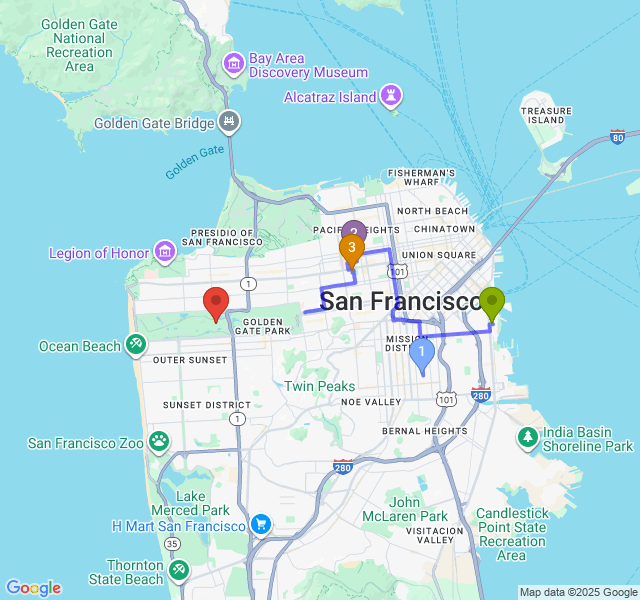



🧪 TEST 2: FOOD & CULTURE ROUTE
📝 Request: 'I want to grab food and see some culture on my way from Mission to North Beach'
💡 Expected: Should discover restaurants, cafes, museums, and cultural sites
🏢 Using Google Places API to discover waypoints...
🌟 GOOGLE PLACES ENHANCED ROUTING
📝 Request: 'I want to grab food and see some culture on my way from Mission to North Beach'
1️⃣ Using LLM for intent understanding...
   📍 Origin: 1671 Mission St, San Francisco, CA 94103
   📍 Destination: 500 Columbus Ave, San Francisco, CA 94133
   🎯 Intent: Experience cultural attractions and grab food along the way, avoiding congested areas while enjoying scenic views
   🧠 LLM Reasoning: North Beach is known for its Italian heritage, historic architecture, and vibrant culture. Mission Street, starting from the mission district, leads to this culturally rich neighborhood. The route can avoid downtown San Francisco by taking a peripheral path along Embarcadero, providing scenic views of the Bay and Fishe

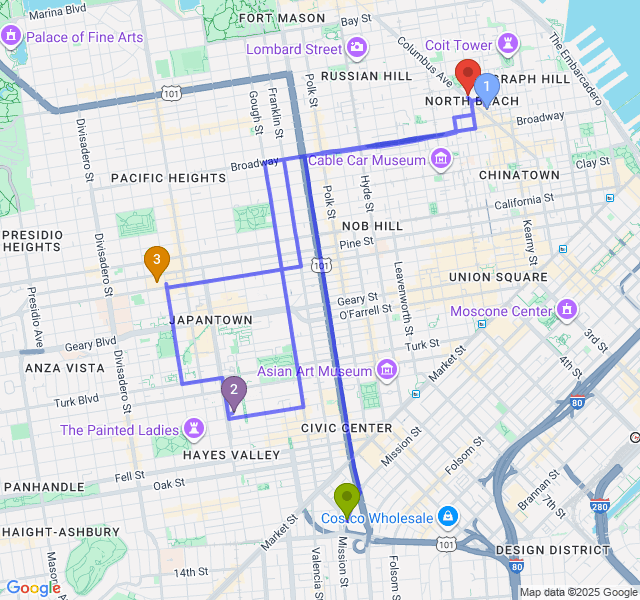



🧪 TEST 3: INSTAGRAM DISCOVERY
📝 Request: 'Show me Instagram-worthy spots from Fisherman's Wharf to Lombard Street'
💡 Expected: Should find tourist attractions and photogenic locations
🏢 Using Google Places API to discover waypoints...
🌟 GOOGLE PLACES ENHANCED ROUTING
📝 Request: 'Show me Instagram-worthy spots from Fisherman's Wharf to Lombard Street'
1️⃣ Using LLM for intent understanding...
   📍 Origin: Fisherman's Wharf, San Francisco, CA 94133, USA
   📍 Destination: Lombard Street, San Francisco, CA 94109, USA
   🎯 Intent: The user wants to explore Instagram-worthy spots along the route that offer scenic views, famous landmarks, and photogenic opportunities.
   🧠 LLM Reasoning: The route connects two popular tourist destinations in San Francisco: Fisherman's Wharf and Lombard Street. To fulfill the user's intent, we should consider intermediate points that offer scenic views of the city and bay, as well as iconic landmarks.

2️⃣ Using Google Places to discover waypoints...
🏢 GOOGL

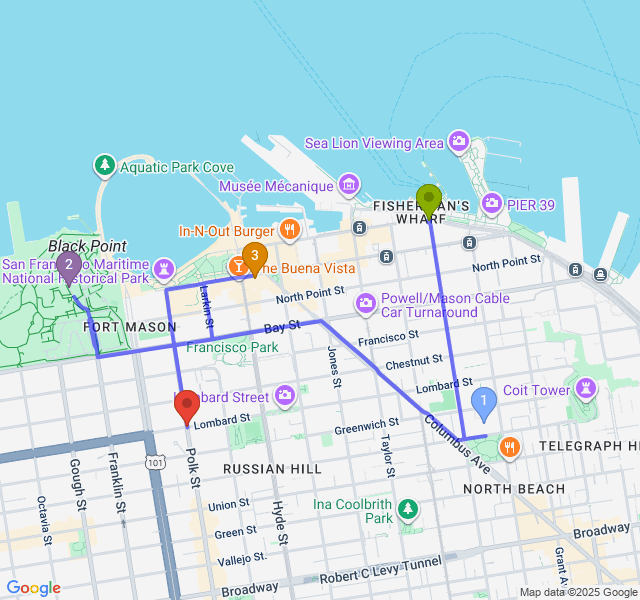



🎉 ALL GOOGLE PLACES TESTS COMPLETE!
✅ System now discovers real places along routes using Google Places API
🏢 Waypoints are actual businesses, attractions, and points of interest
🎯 Much more reliable than LLM-only waypoint suggestions!


In [84]:
# 🧪 TEST GOOGLE PLACES ENHANCED ROUTING
# Test the new system that discovers real places along the route

print("🧪 TESTING GOOGLE PLACES ENHANCED ROUTING")
print("This system uses Google Places API to find real waypoints along the route path")
print("=" * 70)

# Enhanced visualization function for Google Places routes
def visualize_places_enhanced_route(result: Dict[str, Any], title: str = "Places Enhanced Route"):
    """
    Visualization for Google Places enhanced routes
    """
    print(f"\n🗺️ {title.upper()}")
    print("=" * 60)
    
    # Show LLM intent analysis
    request_info = result.get('request', {})
    intent_analysis = request_info.get('intent_analysis', {})
    
    print(f"🧠 LLM INTENT ANALYSIS:")
    print(f"   🎯 User Intent: {intent_analysis.get('user_intent', 'N/A')}")
    print(f"   🧠 LLM Reasoning: {intent_analysis.get('geographical_reasoning', 'N/A')}")
    
    # Show Google Places discovery results
    discovery = result.get('discovery', {})
    print(f"\n🏢 GOOGLE PLACES DISCOVERY:")
    print(f"   🔍 Total places found: {discovery.get('total_places_found', 0)}")
    print(f"   🔄 Unique places: {discovery.get('unique_places', 0)}")
    print(f"   📍 Search points used: {discovery.get('search_points_used', 0)}")
    print(f"   🏷️ Place types searched: {discovery.get('place_types_searched', [])}")
    
    # Show optimization results
    optimization = result.get('optimization', {})
    print(f"\n🔧 SMART FILTERING:")
    print(f"   📊 Discovered waypoints: {optimization.get('discovered_waypoints', 0)}")
    print(f"   🎯 Final optimized waypoints: {optimization.get('final_waypoints', 0)}")
    print(f"   🔧 Filtering applied: {'Yes' if optimization.get('filtering_applied', False) else 'No'}")
    
    # Show route comparison
    baseline = optimization.get('baseline_route', {})
    if baseline:
        route_info = result['route']['route']
        print(f"\n📊 ROUTE COMPARISON:")
        print(f"   🚗 Direct Route: {baseline.get('distance_text', 'N/A')} in {baseline.get('duration_text', 'N/A')}")
        print(f"   🏢 Places Route: {route_info.get('distance', 'N/A')} in {route_info.get('duration', 'N/A')}")
        print(f"   🛣️ Route legs: {route_info.get('total_legs', 1)}")
    
    # Show final Google Places waypoints
    waypoints = result.get('waypoints', [])
    if waypoints:
        print(f"\n📍 GOOGLE PLACES WAYPOINTS:")
        for i, wp in enumerate(waypoints, 1):
            print(f"   {i}. {wp.get('location', 'Unknown')}")
            print(f"      📍 Address: {wp.get('address', 'Not available')}")
            print(f"      ⭐ Rating: {wp.get('rating', 'N/A')}")
            print(f"      🏷️ Type: {wp.get('types', ['Unknown'])[0].replace('_', ' ').title()}")
            print(f"      🏆 Relevance Score: {wp.get('relevance_score', 0):.2f}")
            print(f"      🏢 Source: {wp.get('source', 'Unknown')}")
    
    # Generate map visualization
    api_key = os.getenv('GOOGLE_MAPS_API_KEY')
    if not api_key:
        print("❌ Google Maps API key required for visualization")
        return
    
    route_data = result['route']['route']
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    
    params = [
        "size=800x600",
        "maptype=roadmap",
        f"key={api_key}",
        f"markers=color:green|label:START|{quote(route_data['origin'])}",
        f"markers=color:red|label:END|{quote(route_data['destination'])}"
    ]
    
    # Add Google Places waypoint markers
    colors = ['blue', 'purple', 'orange', 'yellow', 'pink']
    for i, wp in enumerate(waypoints):
        color = colors[i % len(colors)]
        if 'address' in wp and wp['address']:
            marker_label = f"{i+1}"
            params.append(f"markers=color:{color}|label:{marker_label}|{quote(wp['address'])}")
    
    # Add route polyline
    if 'overview_polyline' in result['route']:
        polyline_data = result['route']['overview_polyline']
        params.append(f"path=color:0x0000ff|weight:4|enc:{polyline_data}")
    
    map_url = f"{base_url}?" + "&".join(params)
    
    try:
        print(f"\n🎨 GENERATING GOOGLE PLACES ENHANCED MAP...")
        response = requests.get(map_url, timeout=15)
        
        if response.status_code == 200:
            filename = f'places_enhanced_route_{title.lower().replace(" ", "_")}.png'
            with open(filename, 'wb') as f:
                f.write(response.content)
            
            print("✅ Google Places enhanced map generated!")
            print("🏢 Map shows real places discovered along the route path")
            display(Image(filename, width=800))
            
            # Clean up
            try:
                os.remove(filename)
            except:
                pass
        else:
            print(f"❌ Map generation failed: HTTP {response.status_code}")
            print(f"🔗 Map URL: {map_url}")
            
    except Exception as e:
        print(f"❌ Error generating map: {e}")
        print(f"🔗 Map URL: {map_url}")

# Test cases for Google Places enhanced routing
places_test_cases = [
    {
        "request": "Take me on a scenic drive from Union Square to Golden Gate Park with beautiful views",
        "title": "Scenic Places Discovery",
        "expected": "Should find parks, viewpoints, and scenic attractions along the route"
    },
    {
        "request": "I want to grab food and see some culture on my way from Mission to North Beach",
        "title": "Food & Culture Route",
        "expected": "Should discover restaurants, cafes, museums, and cultural sites"
    },
    {
        "request": "Show me Instagram-worthy spots from Fisherman's Wharf to Lombard Street",
        "title": "Instagram Discovery",
        "expected": "Should find tourist attractions and photogenic locations"
    }
]

print(f"🎯 Running {len(places_test_cases)} Google Places test cases...")
print("Each test will discover real places using Google Places API")
print("\n" + "=" * 70)

# Run each test case
for i, test_case in enumerate(places_test_cases, 1):
    print(f"\n🧪 TEST {i}: {test_case['title'].upper()}")
    print("=" * 60)
    print(f"📝 Request: '{test_case['request']}'")
    print(f"💡 Expected: {test_case['expected']}")
    print("🏢 Using Google Places API to discover waypoints...")
    
    try:
        # Generate Google Places enhanced route
        places_result = places_enhanced_router.create_places_enhanced_route(test_case['request'])
        
        if places_result.get('status') == 'success':
            print(f"\n✅ Test {i} completed successfully!")
            
            # Visualize the result
            visualize_places_enhanced_route(places_result, test_case['title'])
            
        else:
            print(f"❌ Test {i} failed: {places_result.get('error', 'Unknown error')}")
            
    except Exception as e:
        print(f"❌ Test {i} error: {e}")
    
    print("\n" + "=" * 60)

print(f"\n🎉 ALL GOOGLE PLACES TESTS COMPLETE!")
print("✅ System now discovers real places along routes using Google Places API")
print("🏢 Waypoints are actual businesses, attractions, and points of interest")
print("🎯 Much more reliable than LLM-only waypoint suggestions!")
